# Optional Assigment - BBC news archive
This week you will build on last week’s exercise where you tokenized words from the BBC news reports dataset. This dataset contains articles that are classified into a number of different categories. See if you can design a neural network that can be trained on this dataset to accurately determine what words determine what category. Create the vecs.tsv and meta.tsv files and load them into the embedding projector.

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [1]:
import re
import time
import pandas as pd
import numpy as np
import nltk
from nltk import *
import json

import random
random.seed(10)

from joblib import dump, load

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score

# Ejemplo con Stack de RNNs
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, LSTM, SpatialDropout1D
from keras.models import Sequential, load_model
from keras.losses import SparseCategoricalCrossentropy

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score #son metricas - area debajo de la curva roc

from sklearn.model_selection import train_test_split


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



In [2]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# bbc-text.csv
# !gdown --id 1rX10xeI3eUJmOLsc4pOPY6AnCLO8DxNj

In [3]:
vocab_size = 2000
embedding_dim = 32
max_length = 350
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .7

In [4]:
corpus_esA = pd.read_csv("tweets_search_etiquetas_clean.csv", sep = ";", encoding = "latin-1")
idA = corpus_esA[corpus_esA.columns[0]]
X_textA = list(corpus_esA[corpus_esA.columns[3]].fillna(' ').values)
y_hsA = corpus_esA[[corpus_esA.columns[5], corpus_esA.columns[6], corpus_esA.columns[7]]].values
y_hsA = np.array(list(map(lambda x: list(x), list(y_hsA))))
#y_hsA = list(y_hsA)

corpus_esA.tail()


,id_str,created_at,screen_name,text,user_followers,sentiment,funcionality,client_attention,sentiment_code
308,153653000000000,Tue Jun 20 01:55:56 +0000 2022,pruebaTrainDummy,huawei p lite repente apaga malo,1,0,1,0,1
309,153653000000000,Tue Jun 20 01:55:56 +0000 2022,pruebaTrainDummy,camara huawei funciona bien noche,1,0,1,0,1
310,153653000000000,Tue Jun 20 01:55:56 +0000 2022,pruebaTrainDummy,huawei calienta demasiado,1,0,1,0,1
311,153653000000000,Tue Jun 20 01:55:56 +0000 2022,pruebaTrainDummy,colores fotos huawei estan saturados malos,1,0,1,0,1
312,153653000000000,Tue Jun 20 01:55:56 +0000 2022,pruebaTrainDummy,contento huawei colores estan saturados,1,0,1,0,1


In [5]:
corpus_train_esA, corpus_dev_esA = train_test_split(corpus_esA, test_size=0.3)


In [8]:
train_idA = corpus_train_esA[corpus_train_esA.columns[0]]
X_train_textA = list(corpus_train_esA[corpus_train_esA.columns[3]].fillna(' ').values)
y_train_hsA = corpus_train_esA[[corpus_train_esA.columns[5], corpus_train_esA.columns[6], corpus_train_esA.columns[7]]].values
y_train_hsA = np.array(list(map(lambda x: list(x), list(y_train_hsA))))
#y_hsA = list(y_hsA)

test_idA = corpus_dev_esA[corpus_dev_esA.columns[0]]
X_test_textA = list(corpus_dev_esA[corpus_dev_esA.columns[3]].fillna(' ').values)
y_test_hsA = corpus_dev_esA[[corpus_dev_esA.columns[5], corpus_dev_esA.columns[6], corpus_dev_esA.columns[7]]].values
y_test_hsA = np.array(list(map(lambda x: list(x), list(y_test_hsA))))
#y_hsA = list(y_hsA)

In [25]:
import random
train_size = int(len(X_textA) * training_portion)

X_train_textA = X_textA[0:train_size]
y_train_hsA = y_hsA[0:train_size]

X_test_textA = X_textA[train_size:]
y_test_hsA = y_hsA[train_size:]
"""
print(train_labels[0:10])
print(train_sentences[0])
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))
"""

'\nprint(train_labels[0:10])\nprint(train_sentences[0])\nprint(len(train_labels))\nprint(len(validation_sentences))\nprint(len(validation_labels))\n'

In [10]:
# propio
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_textA)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_textA)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
"""
print(train_sequences[0])
print(train_padded[0])
print(len(train_sequences[0])) # <class 'list'>
print(len(train_padded[0])) # <class 'numpy.ndarray'>

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))
"""

"\nprint(train_sequences[0])\nprint(train_padded[0])\nprint(len(train_sequences[0])) # <class 'list'>\nprint(len(train_padded[0])) # <class 'numpy.ndarray'>\n\nprint(len(train_sequences[1]))\nprint(len(train_padded[1]))\n\nprint(len(train_sequences[10]))\nprint(len(train_padded[10]))\n"

In [11]:
train_padded[0]

array([  1,   1,   1,   1,   1, 640, 360, 208,   2,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [7]:
# original
# sentences List[str] = X_train_textA 

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(train_sequences[0])
print(train_padded[0])
print(len(train_sequences[0])) # <class 'list'>
print(len(train_padded[0])) # <class 'numpy.ndarray'>

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

# Expected Ouput
# 449
# 120
# 200
# 120
# 192
# 120

[96, 176, 1157, 1220, 54, 1122, 742, 1, 85, 1074, 1, 147, 184, 1, 1344, 1311, 1595, 47, 9, 949, 96, 4, 1, 329, 92, 23, 17, 140, 1, 1330, 1, 576, 419, 1277, 72, 1, 1, 1755, 10, 894, 4, 755, 12, 954, 1, 11, 656, 1578, 1053, 414, 4, 1999, 1220, 778, 54, 502, 1497, 1, 1652, 135, 333, 123, 1, 817, 1, 1088, 609, 12, 1, 1, 894, 1, 147, 351, 184, 1, 1, 1, 44, 73, 1, 31, 11, 2, 1, 22, 2, 1397, 145, 454, 9, 138, 1398, 82, 1, 488, 1, 96, 1053, 87, 1, 83, 1, 63, 1, 96, 8, 1123, 634, 85, 1074, 96, 1970, 148, 159, 420, 11, 1, 46, 56, 149, 1221, 85, 1074, 1, 5, 13, 9, 488, 1, 1, 13, 8, 1, 1, 412, 1097, 1, 1376, 616, 1469, 1, 1, 756, 11, 502, 1497, 1, 135, 1918, 410, 895, 1, 1618, 43, 1819, 1, 1, 1, 1, 251, 11, 1, 83, 818, 8, 1089, 1133, 149, 797, 577, 1, 136, 31, 1397, 1820, 445, 4, 90, 955, 117, 23, 17, 22, 1, 1, 42, 1453, 2, 1, 28, 42, 99, 362, 1, 42, 24, 464, 243, 1, 1377, 341, 1, 326, 818, 1134, 22, 1, 1819, 1, 297, 736, 4, 1176, 414, 1, 400, 412, 1, 3, 1312, 1, 1819, 1853, 70, 1, 1, 1794, 333, 1

In [192]:
type(train_padded[0][0])

numpy.int32

In [ ]:
train_padded.shape

(1780, 120)

In [12]:
# propio
validation_sequences = tokenizer.texts_to_sequences(X_test_textA)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 445
# (445, 120)

94
(94, 350)


In [8]:
# original
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 445
# (445, 120)

668
(668, 350)


In [169]:
y_hsA[0]

[0, 0, 0]

In [164]:
# propio
label_tokenizer = Tokenizer(num_words=6)
label_tokenizer.fit_on_texts(y_hsA) # labels y_hsA

training_label_seq = pad_sequences(label_tokenizer.texts_to_sequences(y_train_hsA), padding=padding_type, truncating=trunc_type) # train_labels y_train_hsA
validation_label_seq = pad_sequences(label_tokenizer.texts_to_sequences(y_test_hsA), padding=padding_type, truncating=trunc_type)

print(training_label_seq)
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

AttributeError: 'numpy.int64' object has no attribute 'lower'

In [10]:
# original
label_tokenizer = Tokenizer(num_words=6)
label_tokenizer.fit_on_texts(labels) # labels y_hsA

training_label_seq = pad_sequences(label_tokenizer.texts_to_sequences(train_labels), padding=padding_type, truncating=trunc_type) # train_labels y_train_hsA
validation_label_seq = pad_sequences(label_tokenizer.texts_to_sequences(validation_labels), padding=padding_type, truncating=trunc_type)

print(training_label_seq)
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[[4]
 [2]
 [1]
 ...
 [4]
 [2]
 [4]]
[4]
[2]
[1]
(1557, 1)
[1]
[1]
[5]
(668, 1)


In [183]:
for i in train_padded:
    if type(i) is np.ndarray:
        print(type(i[0]))
    break

<class 'numpy.int32'>


In [13]:
# propio

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

num_epochs = 15
history = model.fit(train_padded, y_train_hsA, epochs=num_epochs, verbose=2) #validation_data=(validation_padded, validation_label_seq) y = training_label_seq



# evaluate the model
scores = model.evaluate(train_padded, y_train_hsA, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

loss, accuracy = model.evaluate(train_padded, y_train_hsA, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
#loss, accuracy = model.evaluate(X_test_cvectorized, y_test_hsA, verbose=False)
#print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

# make predictions
testPredict_stackRNN = model.predict(validation_padded)
print('\t', 'Accuracy', accuracy_score(y_test_hsA, testPredict_stackRNN.round()))

# Expected Output
# Layer (type)                 Output Shape              Param #   
# =================================================================
# embedding (Embedding)        (None, 120, 16)           16000     
# _________________________________________________________________
# global_average_pooling1d (Gl (None, 16)                0         
# _________________________________________________________________
# dense (Dense)                (None, 24)                408       
# _________________________________________________________________
# dense_1 (Dense)              (None, 6)                 150       
# =================================================================
# Total params: 16,558
# Trainable params: 16,558
# Non-trainable params: 0

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 16)           32000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 3)                 75        
                                                                 
Total params: 32,483
Trainable params: 32,483
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
7/7 - 2s - loss: 0.9910 - accuracy: 0.1872 - 2s/epoch - 310ms/step
Epoch 2/15
7/7 - 0s - loss: 0.9789 

In [19]:
training_label_seq[0]

4

In [14]:
#original

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

num_epochs = 15
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, verbose=2) #validation_data=(validation_padded, validation_label_seq) y = training_label_seq



# evaluate the model
#scores = model.evaluate(train_padded, y_train_hsA, verbose=0)
#print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

#loss, accuracy = model.evaluate(train_padded, y_train_hsA, verbose=False)
#print("Training Accuracy: {:.4f}".format(accuracy))
#loss, accuracy = model.evaluate(X_test_cvectorized, y_test_hsA, verbose=False)
#print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

# make predictions
#testPredict_stackRNN = model.predict(validation_padded)
#print('\t', 'Accuracy', accuracy_score(y_test_hsA, testPredict_stackRNN.round()))

# Expected Output
# Layer (type)                 Output Shape              Param #   
# =================================================================
# embedding (Embedding)        (None, 120, 16)           16000     
# _________________________________________________________________
# global_average_pooling1d (Gl (None, 16)                0         
# _________________________________________________________________
# dense (Dense)                (None, 24)                408       
# _________________________________________________________________
# dense_1 (Dense)              (None, 6)                 150       
# =================================================================
# Total params: 16,558
# Trainable params: 16,558
# Non-trainable params: 0

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 350, 16)           32000     
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 24)                408       
                                                                 
 dense_7 (Dense)             (None, 6)                 150       
                                                                 
Total params: 32,558
Trainable params: 32,558
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
49/49 - 5s - loss: 1.7612 - accuracy: 0.2396 - 5s/epoch - 95ms/step
Epoch 2/15
49/49 - 0s - loss: 1.

In [178]:
numpy.ndarray([1.0]) == numpy.ndarray

TypeError: 'float' object cannot be interpreted as an integer

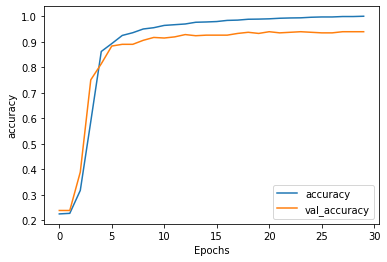

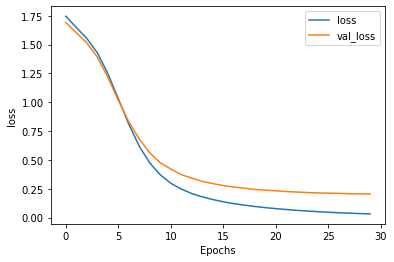

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

reverse_word_index

{1: '<OOV>',
 2: 's',
 3: 'said',
 4: 'will',
 5: 'not',
 6: 'mr',
 7: 'year',
 8: 'also',
 9: 'people',
 10: 'new',
 11: 'us',
 12: 'one',
 13: 'can',
 14: 'last',
 15: 'first',
 16: 't',
 17: 'time',
 18: 'two',
 19: 'world',
 20: 'government',
 21: 'now',
 22: 'uk',
 23: 'years',
 24: 'no',
 25: 'best',
 26: 'just',
 27: 'make',
 28: 'told',
 29: 'get',
 30: 'film',
 31: 'like',
 32: 'game',
 33: 'made',
 34: 'back',
 35: 'music',
 36: 'many',
 37: 'three',
 38: '000',
 39: 'labour',
 40: 'next',
 41: '1',
 42: 'bbc',
 43: 'well',
 44: 'set',
 45: 'number',
 46: 'take',
 47: 'way',
 48: 'added',
 49: 'market',
 50: '2',
 51: 'may',
 52: 'says',
 53: 'company',
 54: 'home',
 55: 'election',
 56: 'off',
 57: 'good',
 58: '2004',
 59: 'going',
 60: 'party',
 61: 'still',
 62: 'games',
 63: 'much',
 64: 'england',
 65: 'win',
 66: '6',
 67: 'go',
 68: 'work',
 69: 'since',
 70: 'firm',
 71: 'second',
 72: 'show',
 73: 'top',
 74: 'blair',
 75: 'won',
 76: 'think',
 77: 'week',
 78: 'use

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights)
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

[[ 0.22072002  0.30217546 -0.09443907 ...  0.07587713  0.0501888
   0.16398147]
 [ 0.36605546  0.07834791 -0.03927483 ... -0.05482148  0.24398205
  -0.10848313]
 [ 0.5404872   0.34970155  0.28020018 ... -0.19820616 -0.00837924
   0.19671452]
 ...
 [-0.1847184  -0.2918262   0.00990822 ... -0.18279012  0.18436743
  -0.5051852 ]
 [ 0.45930123  0.4157743   0.3853054  ... -0.23349401 -0.32057625
  -0.51482815]
 [ 0.61502594  0.19497295  0.6958825  ... -0.6152338  -0.5695931
  -0.652351  ]]
(1000, 16)


In [ ]:
import io

out_v = io.open('output/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('output/meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()